# Videos

In [1]:
import cv2
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
from skeleton import skeleton
from matplotlib.animation import FFMpegWriter
import matplotlib

In [2]:
def read_convergence_info(file):
    f=open(file, "r")
    contents=f.readlines()
    epoch, lr, loss_train, loss_test, err_test = [], [], [], [], []
    for i in range(1,len(contents)):
        line = contents[i][:-1].split('\t')
        epoch.append(float(line[0]))
        lr.append(float(line[1]))
        loss_train.append(float(line[2]))
        loss_test.append(float(line[3]))
        err_test.append(float(line[4]))
        
    return epoch, lr, loss_train, loss_test, err_test

Folders

In [ ]:
experiment = '180919_MDN_CsCh_Fly6_001_SG1_behData_images'
root_folder = '/data/LiftFly3D/DF3D/data_DF3D/'
dims_to_consider = [i for i in range(38) if i not in [15,16,17,18,34,35,36,37]] 

Plot 2D stacked hourglass prediction on images and save as a 25fps video (4x slower)

In [ ]:
G, color_edge = skeleton()
poses = pickle.load(open(root_folder + 'pose_result__data_paper_' + experiment + '.pkl', "rb"))
poses = poses['points2d']
poses = poses[:,:,dims_to_consider,:]
poses.shape

In [ ]:
cam=1 #5 #run twice for cam 1 and 5

#load images
files = glob.glob(root_folder + experiment + '/' + 'camera_' + str(cam) + '*.jpg')
imgs = []
for f in sorted(files):
    img = cv2.imread(f)
    if cam == 5:
        img = np.fliplr(img)
    imgs.append(img)
    
assert imgs != [], 'no files found'    

#filter
poses2d = poses[cam,:,:,:]
poses2d = np.reshape(poses2d, (poses2d.shape[0], poses2d.shape[1]*poses2d.shape[2]))
poses2d = filter_data({'data': poses2d}, window=5, order=2)['data']

fig = plt.figure(figsize=(9.6,4.8))
print(root_folder + experiment + '/' + 'camera_' + str(cam) + '*.jpg')
metadata = dict(title='camera_' + str(cam), artist='LiftFly3D', comment='Watch this!')
writer = FFMpegWriter(fps=25, metadata=metadata)
with writer.saving(fig, root_folder + experiment + "/camera_" + str(cam) + ".mp4", 100):
    for t in range(poses.shape[1]):
        plt.cla()
        
        plt.imshow(imgs[t])
        #plt.text(750, 450, 'Camera ' + str(cam), color='white', size=20)
        
        for i, j in enumerate(G.edges()): 
            x = np.array((poses2d[t,2*j[0]], poses2d[t,2*j[1]]))
            y = np.array((poses2d[t,2*j[0]+1], poses2d[t,2*j[1]+1]))
                   
            plt.plot(x, y, c=color_edge[i], alpha=1.0, linewidth = 2)    
            
        plt.axis('off')
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        
        writer.grab_frame()

Merge videos

In [ ]:
#to create video_1.mp4, execute these commands in sequence in the folder where the images are

#flip camera5 horizontally 
#ffmpeg -i camera_5.mp4 -vf hflip -c:a copy camera_5b.mp4

#stack videos vertically (call this in the folder where the images are)
#ffmpeg -i camera_1.mp4 -i camera_5b.mp4 -filter_complex vstack=inputs=2 stacked.mp4

#annotate
#ffmpeg -i stacked.mp4 -vf drawtext="fontfile=/home/gosztolai/Dropbox/github/fly_data_analysis/Liftfly3D/DF3D/helvetica.ttf: text='camera 1': fontcolor=white: fontsize=24: box=1: boxcolor=black@0.5: boxborderw=5: x=9*(w-text_w)/10: y=9*(h-text_h)/10/2" -codec:a copy stacked_b.mp4
#ffmpeg -i stacked_b.mp4 -vf drawtext="fontfile=/home/gosztolai/Dropbox/github/fly_data_analysis/Liftfly3D/DF3D/helvetica.ttf: text='camera 5': fontcolor=white: fontsize=24: box=1: boxcolor=black@0.5: boxborderw=5: x=9*(w-text_w)/10: y=9*(h-text_h)/10" -codec:a copy stacked_2b.mp4

#stack videos horizontally (call this in the folder where the images are)
#ffmpeg -i prediction_cams.mp4 -i stacked_2b.mp4 -filter_complex "[0:v]scale=-1:960[v0];[v0][1:v]hstack=inputs=2" output.mp4

# Errors

Convergence

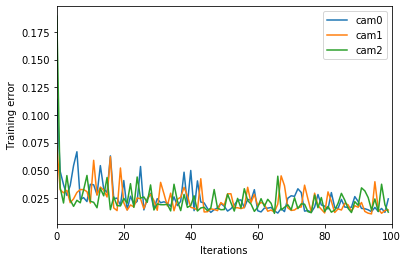

In [4]:
import matplotlib.pyplot as plt
from src.utils import filter_data
root_folder = '/data/LiftFly3D/DF3D/cam_angles/'

for cam in ['cam0', 'cam1', 'cam2']:
    epoch, lr, loss_train, loss_test, err_test = read_convergence_info(root_folder + cam +'/log_train.txt')
    plt.plot(err_test,label=cam)
    
#plt.xscale('log')
plt.xlim([0, 100])
plt.ylabel('Training error')
plt.xlabel('Iterations')
plt.legend()
plt.show()
#plt.savefig('training_error.svg')

Behaviors

In [6]:
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

root_dir = '/data/LiftFly3D/DF3D/behaviors/'
train_dir = ['train_PR', 'train_MDN', 'train_aDN']
test_dir = ['test_PR', 'test_MDN', 'test_aDN']

ttl_err = []
for i in range(3):
    for j in range(3):
        path = os.path.join(root_dir, train_dir[i], test_dir[j])
        all_err = torch.load(path + '/test_results.pth.tar')['all_err']
        ttl_err.append(np.mean(all_err, axis=1))
        #sys.exit()

ttl_err = pd.DataFrame(ttl_err)#.set_index(np.arange(len(ttl_err[0])))
ttl_err.columns.names = ['frame']
ttl_err.index = pd.MultiIndex.from_tuples([('train_PR', 'test_PR'), ('train_PR', 'test_MDN'), ('train_PR', 'test_aDN'), 
                                             ('train_MDN', 'test_PR'), ('train_MDN', 'test_MDN'), ('train_MDN', 'test_aDN'),
                                             ('train_aDN', 'test_PR'), ('train_aDN', 'test_MDN'), ('train_aDN', 'test_aDN')],
                                         names=['train', 'test'])
#pd.MultiIndex.from_arrays(ttl_err, names=('test', 'train'))
#load data in pandas format

(0, 0.2)

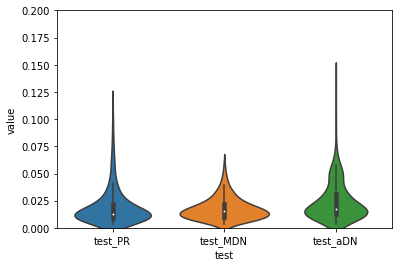

In [75]:
#train PR
ttl_err1 = ttl_err.T
ttl_err1= ttl_err1.loc[:,('train_PR',slice(None))]#
q = ttl_err1.quantile(q=0.99)
ttl_err1 = ttl_err1[ttl_err1<q].melt()
sns.violinplot(x="test", y="value", data=ttl_err1,bw=0.4)
plt.ylim(0, 0.2)

(0, 0.2)

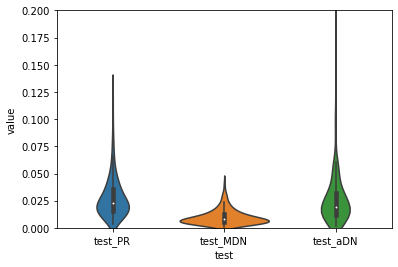

In [74]:
#train MDN
ttl_err1 = ttl_err.T
ttl_err1= ttl_err1.loc[:,('train_MDN',slice(None))]#
q = ttl_err1.quantile(q=0.99)
ttl_err1 = ttl_err1[ttl_err1<q].melt()
sns.violinplot(x="test", y="value", data=ttl_err1,bw=0.4)
plt.ylim(0, 0.2)

(0, 0.2)

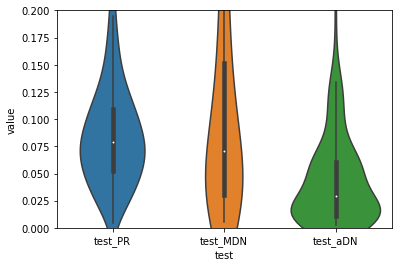

In [73]:
#train aDN
ttl_err1 = ttl_err.T
ttl_err1= ttl_err1.loc[:,('train_aDN',slice(None))]#
q = ttl_err1.quantile(q=0.99)
ttl_err1 = ttl_err1[ttl_err1<q].melt()
sns.violinplot(x="test", y="value", data=ttl_err1,bw=0.4)
plt.ylim(0, 0.2)